# 目的

学習した機械学習器の学習・予測データの予測に寄与した特徴量を可視化する

In [1]:
# 基本的なライブラリ
import warnings
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# パイプライン（imblearn）
from imblearn.pipeline import Pipeline
from imblearn import FunctionSampler

from sksurv.ensemble import (
    ComponentwiseGradientBoostingSurvivalAnalysis,
    GradientBoostingSurvivalAnalysis,
    RandomSurvivalForest,
    ExtraSurvivalTrees,
)

# XAI
import shap

# config python file
import config
import functions

SEED = config.SEED
TARGET_NAME = ["RFS_STATUS", "RFS_MONTHS"]
functions.fix_seed(SEED)


df_recurrenced = pd.read_pickle(
    config.INTERIM_PREPROCESSED_RECURRENCE_DIR + "/df_recurrenced4numeric.pkl"
)

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


# SHAP

In [2]:
def explain_model(
    model_order: dict = {"original_data": []},
    val_step="val_set",
    input_data_path: str = None,
    input_pipe_path: str = None,
    output_file_path: str = None,
):
    # 学習データ・学習済みパイプラインの読み込み
    try:
        _X_train = pd.read_pickle(
            "{0}/{1}/train/X.pkl".format(input_data_path, val_step)
        )
        _y_train = pd.read_pickle(
            "{0}/{1}/train/y.pkl".format(input_data_path, val_step)
        ).to_records(index=False)
        _X_test = pd.read_pickle("{0}/{1}/test/X.pkl".format(input_data_path, val_step))
        _y_test = pd.read_pickle(
            "{0}/{1}/test/y.pkl".format(input_data_path, val_step)
        ).to_records(index=False)

        pipeline_path = "{0}/{1}".format(input_pipe_path, val_step)
        _model_pipeline = functions.pickle_load(
            "{0}/model_pipeline.pkl".format(pipeline_path)
        )
        _estimator = _model_pipeline[-1]
    except:
        print("preprocess pkl file dose not exist")
        return

    # load JS visualization code to notebook
    shap.initjs()

    # explain the model's predictions using SHAP values

    explainer = shap.Explainer(
        _estimator.predict, _X_test, feature_names=_X_test.columns, max_evals=829
    )
    shap_values = explainer(_X_test)
    shap.plots.beeswarm(shap_values)

    if output_file_path:
        save_model_pipeline(
            pipeline=_model_pipeline, val_step=val_step, save_file_path=output_file_path
        )

In [3]:
# 実施したい学習の定義
model_order_dicts = [
    {
        "model_name": ComponentwiseGradientBoostingSurvivalAnalysis().__class__.__name__,
        "preprocess_name": "preprocess4numeric_pca90",
        "model_order": [
            (
                ComponentwiseGradientBoostingSurvivalAnalysis().__class__.__name__,
                ComponentwiseGradientBoostingSurvivalAnalysis(
                    random_state=config.SEED,
                ),
            ),
        ],
    },
    {
        "model_name": GradientBoostingSurvivalAnalysis().__class__.__name__,
        "preprocess_name": "preprocess4numeric_pca90",
        "model_order": [
            (
                GradientBoostingSurvivalAnalysis().__class__.__name__,
                GradientBoostingSurvivalAnalysis(
                    random_state=config.SEED,
                ),
            ),
        ],
    },
    {
        "model_name": RandomSurvivalForest().__class__.__name__,
        "preprocess_name": "preprocess4numeric_pca90",
        "model_order": [
            (
                RandomSurvivalForest().__class__.__name__,
                RandomSurvivalForest(
                    n_estimators=1000,
                    min_samples_split=10,
                    min_samples_leaf=15,
                    n_jobs=-1,
                    random_state=config.SEED,
                ),
            ),
        ],
    },
    {
        "model_name": ExtraSurvivalTrees().__class__.__name__,
        "preprocess_name": "preprocess4numeric_pca90",
        "model_order": [
            (
                ExtraSurvivalTrees().__class__.__name__,
                ExtraSurvivalTrees(
                    random_state=config.SEED,
                ),
            ),
        ],
    },
]

####################################################################################################
subgroup_column:  CLAUDIN_SUBTYPE
subgroup:  claudin-low
....................................................................................................
model_order_dict name:  ComponentwiseGradientBoostingSurvivalAnalysis


Permutation explainer: 19it [00:12,  1.44it/s]                           
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


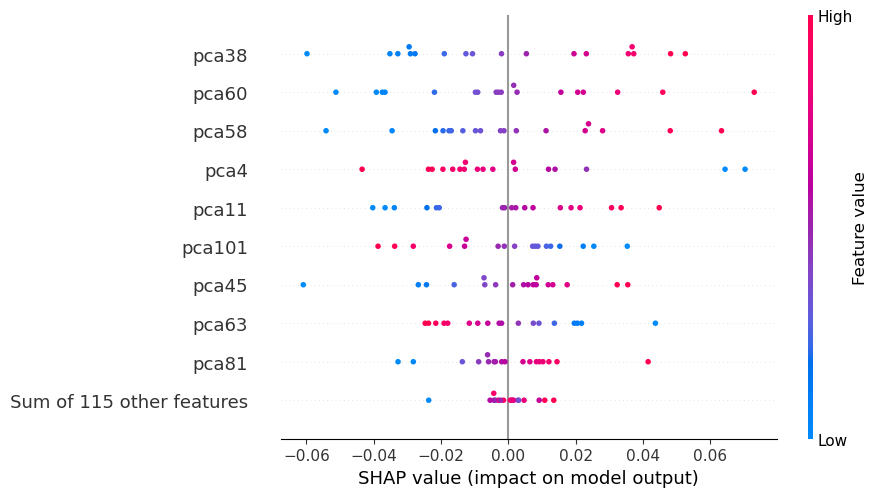

....................................................................................................
model_order_dict name:  GradientBoostingSurvivalAnalysis


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


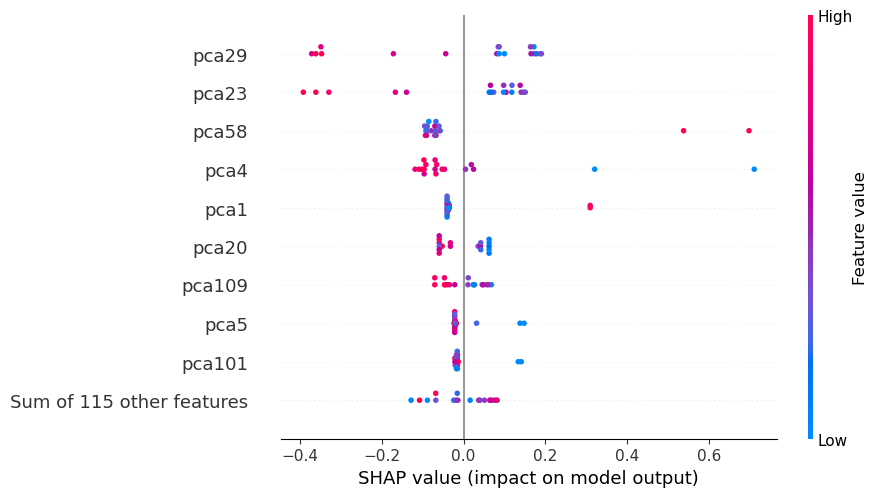

....................................................................................................
model_order_dict name:  RandomSurvivalForest


Permutation explainer: 19it [01:19,  4.99s/it]                           
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


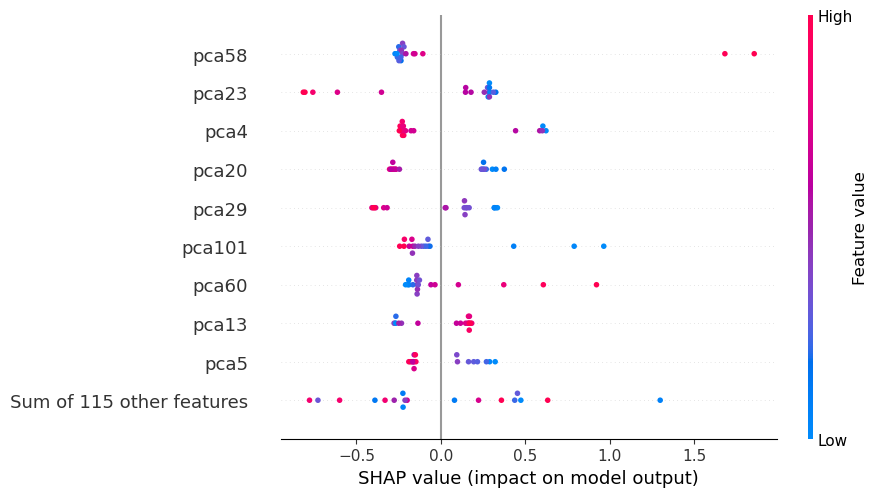

....................................................................................................
model_order_dict name:  ExtraSurvivalTrees


Permutation explainer: 19it [00:28,  2.36s/it]                           
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


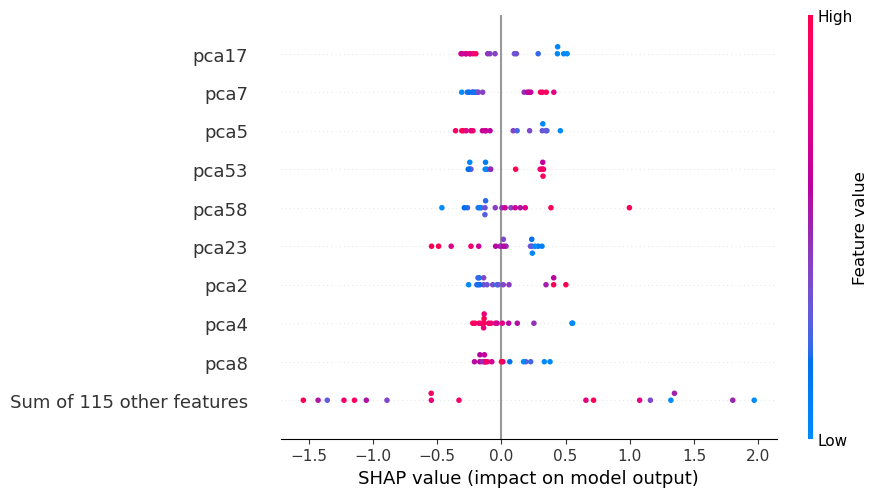

subgroup:  LumA
....................................................................................................
model_order_dict name:  ComponentwiseGradientBoostingSurvivalAnalysis


Permutation explainer: 62it [01:13,  1.39s/it]                           
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


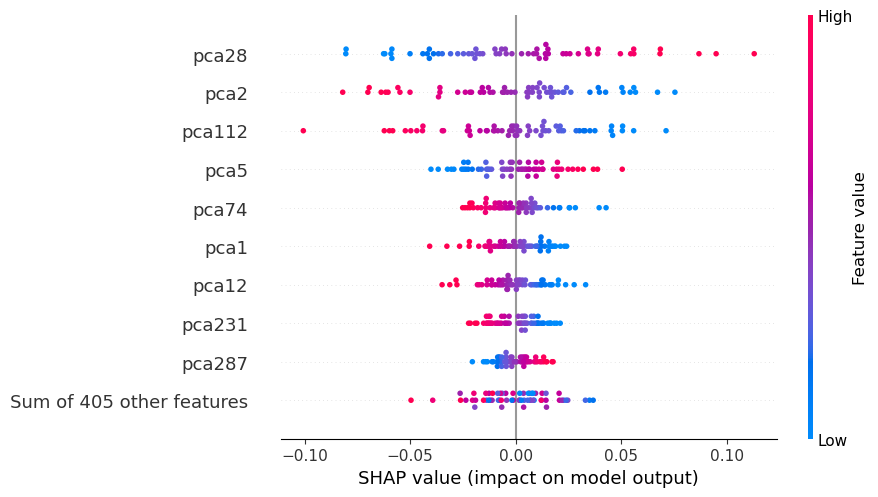

....................................................................................................
model_order_dict name:  GradientBoostingSurvivalAnalysis


Permutation explainer: 62it [02:45,  2.90s/it]                           
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


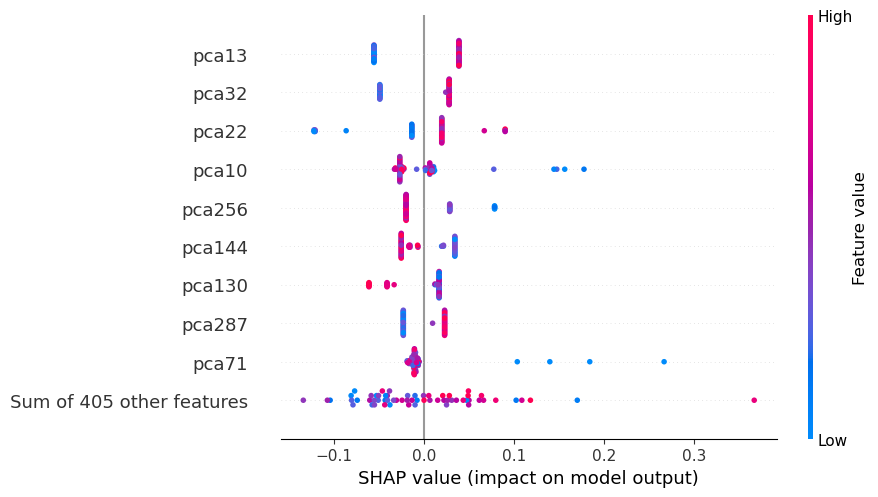

....................................................................................................
model_order_dict name:  RandomSurvivalForest


Permutation explainer:  21%|██▎        | 13/61 [19:07<1:19:38, 99.55s/it]

In [ ]:
# 層別化する特徴量
subgroup_columns = [
    "CLAUDIN_SUBTYPE",
    # "THREEGENE",
]
# 遺伝子発現量以外の特徴量を削除
drop_columns = [
    "CLAUDIN_SUBTYPE",
    "THREEGENE",
]


for subgroup_column in subgroup_columns:  # 各サブグループへの適用
    print("##########" * 10)
    print("subgroup_column: ", subgroup_column)
    for subgroup in df_recurrenced[subgroup_column].unique():  # サブグループの要素毎への適用
        print("==========" * 10)
        print("subgroup: ", subgroup)
        for model_order_dict in model_order_dicts:
            print(".........." * 10)
            print("model_order_dict name: ", model_order_dict["model_name"])
            input_data_path = "./{0}/{1}/{2}/{3}".format(
                config.INTERIM_PREPROCESSED_RECURRENCE_DIR,
                subgroup_column,
                subgroup,
                model_order_dict["preprocess_name"],
            )
            input_pipe_path = "./{0}/{1}/{2}/{3}/{4}".format(
                config.INTERIM_MODELS_RECURRENCE_DIR,
                subgroup_column,
                subgroup,
                model_order_dict["preprocess_name"],
                model_order_dict["model_name"],
            )
            output_file_path = "./{0}/{1}/{2}/{3}/{4}".format(
                config.INTERIM_EXPLAIN_RECURRENCE_DIR,
                subgroup_column,
                subgroup,
                model_order_dict["preprocess_name"],
                model_order_dict["model_name"],
            )
            for val_step in [
                "val_set",
            ]:
                explain_model(
                    model_order=model_order_dict["model_order"],
                    val_step=val_step,
                    input_data_path=input_data_path,
                    input_pipe_path=input_pipe_path,
                )